In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Application to Aquifer Problem

In [2]:
Q = 0.05 # pump rate
S = 1.4e-4 # storing coeff.
T = 0.0006 # transmissivity

In [3]:
# manual integration
from scipy.integrate import quad
from scipy.special import expi

def brunnenfunkt(x):
    """
    Auxilliary function for manually approximating W(u) from the Theiss solution by means of integration
    """
    return np.exp(-x)/x

def W(u):
    """
    W(u) as in the solution provided by Theiss
    """
    arr = np.zeros(u.shape)
    # fill array with nested for-loop
    for i in range(u.shape[0]):
        for j in range(u.shape[1]):
            arr[i,j]= np.array([quad(brunnenfunkt, u[i,j], np.inf, epsabs=1e-20, epsrel=1e-20)[0]])
    return arr

def s(r,t, manual=False):
    """
    Analytic solution by Theiss - either with manual computation of W(u)
    """
    if manual:
        return (Q/(4*np.pi*T))*W(S*r**2/(4*T*t))
    else:
        return -(Q/(4*np.pi*T))*expi(-S*r**2/(4*T*t))

In [4]:
def measure_match_analyticalstencil(num_r, num_t, verbose=False):
    """
    Utility function for measuring the absolute relative difference between regressed and analytically 
    expected stencils. Stencils are expected to be regressed locally.
    num_r : number of datapoints in r
    num_t : corresponding for t
    """
    # generate data
    rs = np.linspace(100,500,num=num_r)
    ts = np.linspace(0.1*60**2,2*60**2, num=num_t)
    rr,tt = np.meshgrid(rs,ts)
    theis = s(rr,tt)
    # compute grid cell sizes
    delta_r = rs[2]-rs[1]
    delta_t = ts[2]-ts[1]
    # regress the local stencils
    stencils = generate_local_stencils_theiss(theis, delta_t)
    # compute max. rel. errors of the respective coefficients
    uim1 = 100*np.max(np.abs((stencils[:,0]-(T/S*(2-delta_r/rs)/(2*delta_r**2)))/(T/S*(2-delta_r/rs)/(2*delta_r**2))))
    uip1 = 100*np.max(np.abs((stencils[:,2]-(T/S*(2+delta_r/rs)/(2*delta_r**2)))/(T/S*(2+delta_r/rs)/(2*delta_r**2))))
    ui = 100*np.max(np.abs((stencils[:,1]-(T/S*(-2)/delta_r**2+0*rs))/(T/S*(-2)/delta_r**2+0*rs)))
    if verbose:
        print("Max. rel. error on u_i-1: {}%".format(round(uim1, 2)))
        print("Max. rel. error on u_i+1: {}%".format(round(uip1, 2)))
        print("Max. rel. error on u_i: {}%".format(round(ui, 2)))
    return delta_r, uim1, uip1, ui

In [5]:
# generate data
rs = np.linspace(100,500,num=50)
ts = np.linspace(0.1*60**2,2*60**2, num=1000)
rr,tt = np.meshgrid(rs,ts)
theis = s(rr,tt)

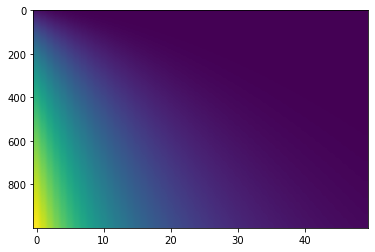

In [6]:
# make image
plt.imshow(theis, aspect="auto")

In [7]:
# grid cell sizes
delta_r = rs[2]-rs[1]
delta_t = ts[2]-ts[1]
print("Delta r:{},\tDelta t:{}".format(delta_r, delta_t))

Delta r:8.16326530612244,	Delta t:6.846846846846859


In [8]:
def generate_local_stencils_theiss(t, delta_t):
    """
    Infer locally constant stencil coefficients, by employing regression along time axis
    t : matrix t_dim x r_dim of the theis solution
    delta_t : grid cell size in time
    """
    stencil_coeffs = np.zeros((t.shape[1], 3)) # array for storing results --> r_dim x 3
    for r_ind in range(1, t.shape[1]-1): # iterate over central node
        X = t[:-1,r_ind-1:r_ind+1+1] # select respective r-elements of the data-matrix. Not include last element, since we don't have an approximation for the time derivative there
        y = (t[:,r_ind]-np.roll(t[:,r_ind], 1))[1:]/delta_t # forward difference scheme to approx. time derivative
        # perform linear regression
        lr = LinearRegression(fit_intercept=False)
        lr.fit(X,y)
        stencil_coeffs[r_ind,:] = lr.coef_ # store local stencil coefficient
    # linear interpolation for points, where left-hand/right-hand side data was not available for regression
    stencil_coeffs[0,:] = stencil_coeffs[1,:] + (stencil_coeffs[1,:]-stencil_coeffs[2,:])
    stencil_coeffs[-1,:] = stencil_coeffs[-2,:] + (stencil_coeffs[-2,:]-stencil_coeffs[-3,:])
    return stencil_coeffs

In [9]:
stencils = generate_local_stencils_theiss(theis, delta_t) # compute the local stencils

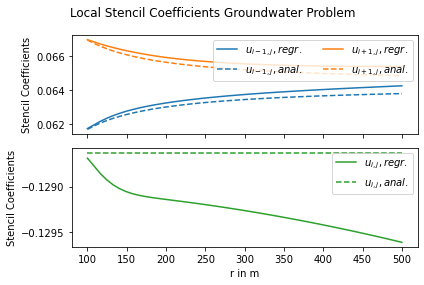

In [10]:
# plot for the paper, along with analytic solution
fig, axs = plt.subplots(ncols=1, nrows = 2, sharex=True)
axs[0].plot(rs, stencils[:,0], label=r"$u_{i-1, j}, regr.$", color="C0")
axs[0].plot(rs, T/S*(2-delta_r/rs)/(2*delta_r**2), label=r"$u_{i-1, j}, anal.$", ls="--", color="C0")
axs[0].plot(rs, stencils[:,2], label=r"$u_{i+1, j}, regr.$", color="C1")
axs[0].plot(rs, T/S*(2+delta_r/rs)/(2*delta_r**2), label=r"$u_{i+1, j}, anal.$", ls="--", color="C1")
axs[0].legend(ncol=2, loc="upper right")
axs[0].set_ylabel("Stencil Coefficients")
axs[1].plot(rs, stencils[:,1], label=r"$u_{i, j}, regr.$", color="C2")
axs[1].plot(rs, T/S*(-2)/delta_r**2+0*rs, label=r"$u_{i,j}, anal.$", ls="--", color="C2")
axs[1].legend()
axs[1].set_ylabel("Stencil Coefficients")
axs[1].set_xlabel("r in m")
fig.suptitle("Local Stencil Coefficients Groundwater Problem")
fig.tight_layout()

In [11]:
# compute max. rel. errors of the respective coefficients
print("Max. rel. error on u_{i-1}:", 100*np.max(np.abs((stencils[:,0]-(T/S*(2-delta_r/rs)/(2*delta_r**2)))/(T/S*(2-delta_r/rs)/(2*delta_r**2)))))
print("Max. rel. error on u_{i+1}:", 100*np.max(np.abs((stencils[:,2]-(T/S*(2+delta_r/rs)/(2*delta_r**2)))/(T/S*(2+delta_r/rs)/(2*delta_r**2)))))
print("Max. rel. error on u_{i}:", 100*np.max(np.abs((stencils[:,1]-(T/S*(-2)/delta_r**2+0*rs))/(T/S*(-2)/delta_r**2+0*rs))))

Max. rel. error on u_{i-1}: 0.7152882228834178
Max. rel. error on u_{i+1}: 0.8309210563197139
Max. rel. error on u_{i}: 0.7704868521941552


In [12]:
def localstencil_propagateTheiss_vonNeumann(X, X_true, n, stencils, delta_t):
    """
    Recursive function to propagate a given state using the local stencil coefficients and a forward scheme in time
    X : matrix to fill recursively
    X_true : correct solution, only required for the boundaries
    n : timestep to fill in this iteration
    stencils : local stencil coefficients
    delta_t : grid cell size in time
    """
    if n==X.shape[0]: # if matrix is fully pupolated
        return X # abort
    for r_ind in range(1, X.shape[1]-1):# iterate over central node
        # populate this central r-position one timestep ahead
        X[n, r_ind] = X[n-1, r_ind] + delta_t*(stencils[r_ind,0]*X[n-1,r_ind-1] + stencils[r_ind,1]*X[n-1,r_ind] + stencils[r_ind,2]*X[n-1,r_ind+1])
    # boundaries by analytic solution
    X[n,0] = X_true[n,0] 
    X[n,-1] = X_true[n,-1]
    # one time step ahead
    return localstencil_propagateTheiss_vonNeumann(X, X_true, n+1, stencils, delta_t)

In [13]:
# generate test set 400 further timesteps + 1 old time steps
X = np.zeros((401,len(rs)))
# first element corresponds to last element from training set
X[0,:] = theis[-1,:]

# corresponding new t values in order to generate analytic solution on test set
tsnew = np.linspace(ts[-1],ts[-1]+(X.shape[0]-1)*delta_t, num=X.shape[0])
rr,tt = np.meshgrid(rs,tsnew)
X_anal_sol = s(rr,tt)

In [14]:
def generateFromMatrix_Theiss(theiss, rs, delta_t):
    """
    generate matrices for static regression problem, where we include the non-const. cofficient 1/r into the variables
    theiss: matrix with theiss solution
    """
    X = np.zeros(((theiss.shape[0]-1)*(theiss.shape[1]-2),5)) # empty matrix for storing the results
    y = np.zeros(X.shape[0]) # corresponding RHS
    x_idx = 0 # line to fill
    for t_ind in range((theiss.shape[0]-1)): # iterate over all available times, except the last one, because we don't have a forward time for this one
        for r_ind in range((theiss.shape[1]-2)): # iterate over left-most node on symm. 3-pt stencil
            # fill line, including the variables with 1/r factor
            X[x_idx,:] = [theiss[t_ind, r_ind], theiss[t_ind, r_ind+1], theiss[t_ind, r_ind+2], theiss[t_ind, r_ind]/rs[r_ind+1],theiss[t_ind, r_ind+2]/rs[r_ind+1]]
            y[x_idx] = (theiss[t_ind+1, r_ind+1]-theiss[t_ind, r_ind+1])/delta_t # forward diff.
            x_idx +=1
    return X,y

In [15]:
# test cheaty stencil, where 1/r is included into regression problem
def cheaty_stencil(theis, rs, delta_t):
    """
    Computes stencil cofficients, where the 1/r factor is incorporated into the regression problem
    """
    X,y = generateFromMatrix_Theiss(theis, rs, delta_t) # generate regression problem
    lr = LinearRegression(fit_intercept=False) # perform OLS fit
    lr.fit(X,y)
    stencil = lr.coef_
    return stencil

# constant coefficients only
def very_stupid_stencil(theis, rs, delta_t):
    """
    Computes stencil coefficients by full neglection of any variable coefficients.
    """
    X,y = generateFromMatrix_Theiss(theis, rs, delta_t) # generate regression problem, including the 1/r variables
    X = X[:,0:3] # select only the nodes, without the incorporated factors
    lr = LinearRegression(fit_intercept=False) # perform OLS fit
    lr.fit(X,y)
    stencil = lr.coef_
    return stencil

In [16]:
def stupid_propagateTheiss_vonNeumann(X, X_true, rs, n, stencil, delta_t):
    """
    Recursive function to propagate an initial state using the stencils regressed by manual incorporation of the variable coeffs.
    X : matrix to populate
    X_true : true solution on this interval, only used for boundaries
    rs : r values on the domain
    n : line to fill
    delta_t : timestep
    """
    if n==X.shape[0]: # if finished
        return X # terminate
    for r_ind in range(0,X.shape[1]-2): # iterate over left-most node on the three-point stencil
        # populate
        X[n,r_ind+1] = X[n-1,r_ind+1]+delta_t*(X[n-1, r_ind]*stencil[0]+stencil[1]*X[n-1, r_ind+1]+stencil[2]*X[n-1, r_ind+2]+stencil[3]*X[n-1, r_ind]/rs[r_ind+1]+stencil[4]*X[n-1, r_ind+2]/rs[r_ind+1])
    # use boundaries
    X[n,0] = X_true[n,0]
    X[n,-1] = X_true[n,-1]
    # next call
    return stupid_propagateTheiss_vonNeumann(X, X_true, rs, n+1, stencil, delta_t)

In [17]:
# regress stencil coefficients by manual incorporation of variable coeff.
stupid_stencil = cheaty_stencil(theis, rs, delta_t)
# expected values from classical finite-element discretization
stupid_stencil_exp = np.array([T/(S*delta_r**2), -2*T/(S*delta_r**2), T/(S*delta_r**2), -T/(2*S*delta_r), T/(2*S*delta_r)])
# regress stencil coefficients by full neglection of variable coeff.
very_stupid_stencil = very_stupid_stencil(theis, rs, delta_t)
very_stupid_stencil = np.hstack((very_stupid_stencil, [0,0])) # bring to same shape as the "stupid-stencil" variable

In [18]:
(stupid_stencil-stupid_stencil_exp)/stupid_stencil_exp*100

array([0.23904446, 0.24502195, 0.25112324, 0.69673114, 0.77245708])

In [19]:
#  use all three different approaches to propagate the last state of the training interval for 400 time steps
X_prop_reg = localstencil_propagateTheiss_vonNeumann(X.copy(), X_anal_sol, 1, stencils, delta_t)
X_prop_reg_stupid = stupid_propagateTheiss_vonNeumann(X.copy(), X_anal_sol, rs, 1, stupid_stencil, delta_t)
X_prop_reg_very_stupid = stupid_propagateTheiss_vonNeumann(X.copy(), X_anal_sol, rs, 1, very_stupid_stencil, delta_t)

In [20]:
# compute mean absolute error (MAE)
print("MAE sliding window approach: {}".format(np.mean(np.abs(X_prop_reg[1:]-X_anal_sol[1:]))))
print("MAE manual incorporation: {}".format(np.mean(np.abs(X_prop_reg_stupid[1:]-X_anal_sol[1:]))))
print("MAE neglection variable coeff: {}".format(np.mean(np.abs(X_prop_reg_very_stupid[1:]-X_anal_sol[1:]))))

MAE sliding window approach: 0.0004317258604298587
MAE manual incorporation: 0.0002160034471416296
MAE neglection variable coeff: 0.25699773720102886


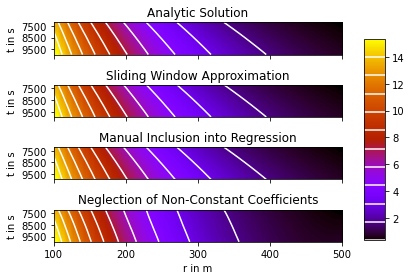

In [22]:
fig, axs = plt.subplots(ncols=1, nrows=4, sharex=True, sharey=True)
vmax = max([np.max(X_anal_sol), np.max(X_prop_reg), np.max(X_prop_reg_stupid), np.max(X_prop_reg_very_stupid)])
vmin = min([np.max(X_anal_sol), np.min(X_prop_reg), np.min(X_prop_reg_stupid), np.min(X_prop_reg_very_stupid)])

axs[1].imshow(X_prop_reg[1:], aspect="auto", vmax=vmax, vmin=vmin, cmap=plt.get_cmap("gnuplot"), extent=[rs[0],rs[-1],tsnew[-1],tsnew[0]])
axs[1].contour(X_prop_reg[1:], levels=np.linspace(vmin, vmax,num=12), colors="white",extent=[rs[0],rs[-1],tsnew[0],tsnew[-1]])
axs[1].set_title("Sliding Window Approximation")
axs[1].set_ylabel("t in s")
axs[1].set_yticks([7500, 8500, 9500])

axs[2].imshow(X_prop_reg_stupid[1:], aspect="auto", vmax=vmax, vmin=vmin, cmap=plt.get_cmap("gnuplot"),extent=[rs[0],rs[-1],tsnew[-1],tsnew[0]])
axs[2].contour(X_prop_reg_stupid[1:], levels=np.linspace(vmin, vmax,num=12), colors="white",extent=[rs[0],rs[-1],tsnew[0],tsnew[-1]])
axs[2].set_title("Manual Inclusion into Regression")
axs[2].set_ylabel("t in s")
axs[2].set_yticks([7500, 8500, 9500])
#axs[1].set_xlabel("r in m")


im = axs[3].imshow(X_prop_reg_very_stupid[1:], aspect="auto", vmax=vmax, vmin=vmin, cmap=plt.get_cmap("gnuplot"),extent=[rs[0],rs[-1],tsnew[-1],tsnew[0]])
axs[3].contour(X_prop_reg_very_stupid[1:], levels=np.linspace(vmin, vmax,num=12), colors="white",extent=[rs[0],rs[-1],tsnew[0],tsnew[-1]])
axs[3].set_title("Neglection of Non-Constant Coefficients")
axs[3].set_ylabel("t in s")
axs[3].set_yticks([7500, 8500, 9500])
#axs[2].set_xlabel("r in m")

#axs[0].set_ylabel("t in s")

axs[0].imshow(X_anal_sol[1:], aspect="auto", vmax=vmax, vmin=vmin, cmap=plt.get_cmap("gnuplot"),extent=[rs[0],rs[-1],tsnew[-1],tsnew[0]])
contl = axs[0].contour(X_anal_sol[1:], levels=np.linspace(vmin, vmax,num=12), colors="white",extent=[rs[0],rs[-1],tsnew[0],tsnew[-1]])
axs[0].set_title("Analytic Solution")
axs[0].set_ylabel("t in s")
axs[0].set_yticks([7500, 8500, 9500])


axs[3].set_xlabel("r in m")
axs[3].set_xticks([100,200,300,400,500])
axs[3].xaxis.set_ticks_position('bottom')

fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
colorbar = fig.colorbar(im, cax=cbar_ax)
colorbar.add_lines(contl)

## Reviewer's Question on Window Size

In [23]:
# plot the max. abs. rel. differenceof the regressed stencil coefficients vs window size

d_rs = []
uim1s = []
uip1s = []
uis = []

num_t = 1000 # constant time step --> as before
num_rs = np.logspace(np.log10(20),np.log10(250),num=100,dtype=np.int64) # spatial domain is constant, number of nodes increases
# iterate over possible number of nodes
for num_r in num_rs:
    # grid cell size, max. abs. rel. difference per component
    delta_r, uim1, uip1, ui = measure_match_analyticalstencil(num_r, num_t)
    # append to lists
    d_rs.append(delta_r)
    uim1s.append(uim1)
    uip1s.append(uip1)
    uis.append(ui)

In [24]:
# print best configuration
all_maes = np.array([uim1s, uip1s, uis])
worst_mae = np.max(all_maes, axis=0)
print("Minimal max. rel. error is {}% at Delta_r={}m".format(round(np.min(worst_mae), 2), d_rs[np.argmin(worst_mae)]))

Minimal max. rel. error is 0.22% at Delta_r=12.5m


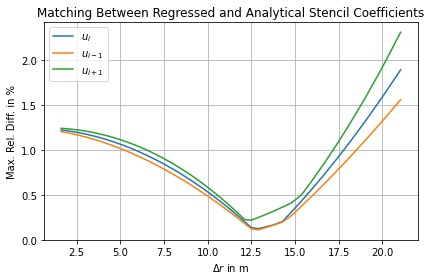

In [25]:
# quick visualization
plt.plot(d_rs, uis, label="$u_i$")
plt.plot(d_rs, uim1s, label="$u_{i-1}$")
plt.plot(d_rs, uip1s, label="$u_{i+1}$")
plt.grid()
plt.legend()
plt.ylabel("Max. Rel. Diff. in %")
plt.xlabel("$\Delta r$ in m")
plt.title("Matching Between Regressed and Analytical Stencil Coefficients")
plt.tight_layout()